<a href="https://colab.research.google.com/github/yellowlarva-sketch/aml-fraud-detection/blob/main/02b_manualbinning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Transactions for Anti Money Laundering

We aim to develop a predictive model that identifies potential money laundering cases by analyzing patterns in historical account transaction data.

Import Data from Kaggle Project
https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/code

In [89]:
!pip install optbinning

In [90]:
# Connect drive to save data
from google.colab import drive
drive.mount('/content/drive')

# Set directory
main_dir = '/content/drive/My Drive/Colab Notebooks/'
input_dir = main_dir + '/00_inputs/'
script_dir = main_dir + '/01_scripts/'
output_dir = main_dir + '/02_outputs/'
model_ver = 'modelv1'
model_dir = output_dir + '{0}/'.format(model_ver)
non_predictive_cols = ['Account','Is Laundering',  'X_fold','biz_dt']

# Import libraries
# %pip install 'cvxpy<1.5' ecos scs
import pandas as pd
import numpy as np
import math
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from optbinning import BinningProcess
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir(script_dir)

from utils import roc_curve_graph

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here we are predicting whether the account was involved in the laundering activity. Import data and check target label.


In [91]:
df = pd.read_csv(output_dir + 'modeling_data.csv')
print("Data shape:",df.shape)

predictive_cols = pd.read_csv(output_dir + 'predictive_columns.csv')
id_col = 'Account'
target = 'Is Laundering'
features = list(predictive_cols['0'])
print("Number of features:",len(features))

df[target].value_counts(normalize=False)

Data shape: (1550716, 45)
Number of features: 41


,count
Is Laundering,
0,1546751
1,3965


Split the train and test and out of time validation set.

In [92]:
# This will be used for cross-validation hyperparameter tuning
X_train = df[df['X_fold'].isin(['train', 'valid'])][features].head(10000)
y_train = df[df['X_fold'].isin(['train', 'valid'])][target].head(10000)

# This will be used for model algorithm comparison & setting optimal threshold
X_test = df[df['X_fold'] == 'test'][features]
y_test = df[df['X_fold'] == 'test'][target]

# This will be used for model algorithm comparison & setting optimal threshold
X_oot = df[df['X_fold'] == 'outoftime'][features]
y_oot = df[df['X_fold'] == 'outoftime'][target]

Define model parameter search space

In [191]:
search_space = {
    'max_n_bins': hp.choice('max_n_bins', [5, 10, 20]),
    'monotonic_trend': hp.choice('monotonic_trend', ['auto', 'ascending', 'descending']),
    'num_features': hp.choice('num_features', [10, 20, 30]),
    'm_method': hp.choice('m_method', ['lr', 'rf']),

        # Logistic regression params
    'C': hp.loguniform('C', np.log(0.01), np.log(10)),
    'n_estimators': hp.choice('n_estimators', [100, 200]),
    'max_depth': hp.choice('max_depth', [5, 10, None]),

}

model_config = {
  'lr':{
    # Logistic regression params
    'C': hp.loguniform('C', np.log(0.01), np.log(10)),
  },
  'rf':{
    # Random forest params
    'n_estimators': hp.choice('n_estimators', [100, 200]),
    'max_depth': hp.choice('max_depth', [5, 10, None]),
  }
}

In [192]:
special_codes = [0]
binning_fit_params = {
    'Amount Received': {'monotonic_trend': 'descending'},
    'Amount Paid': {'monotonic_trend': 'ascending'},
    'Payment Format_ACH': {'monotonic_trend': 'ascending'},
    'Payment Format_Cheque': {'monotonic_trend': 'auto'},
    'Payment Format_Credit Card': {'monotonic_trend': 'auto'},
    'Payment Currency_Euro': {'monotonic_trend': 'ascending'},
    'Payment Currency_US Dollar': {'monotonic_trend': 'ascending'},
    'Receiving Currency_Euro': {'monotonic_trend': 'ascending'},
    'Receiving Currency_US Dollar': {'monotonic_trend': 'ascending'},
    'self_transfer': {'monotonic_trend': 'descending'},
    'Account.1': {'monotonic_trend': 'ascending'}
}

In [193]:
def binning_model_selection(params): #, X_train, y_train, features
    max_n_bins = params['max_n_bins']
    monotonic_trend = params['monotonic_trend']
    num_features = params['num_features']
    m_method = params['m_method']

    # Step 1: Binning
    to_update_bin = binning_fit_params.copy()
    to_update_bin.update( {
            var: {"monotonic_trend": "auto"}
            for var in features if var not in binning_fit_params.keys()
        })

    bp = BinningProcess(
    variable_names=features,
    selection_criteria={"iv": {"min": 0.01}}, #"woe_monotonicity": {"min": 90}, "min_event_rate_diff":
    max_n_bins =max_n_bins,
    binning_fit_params=to_update_bin,
    special_codes=special_codes
    )
    params['binning_fit_params'] = to_update_bin

    bp.fit(X_train, y_train)
    X_binned = bp.transform(X_train) #, metric="woe"

    # X_train_woe[feature] = binning.transform(X_train[feature], metric="woe")

    # Step 2: Feature selection
    selector = SelectKBest(score_func=mutual_info_classif, k=num_features)
    X_selected = selector.fit_transform(X_binned, y_train)

    # Step 3: Model selection
    if m_method == 'lr':
        model = LogisticRegression(C=params['C'], solver='liblinear')
    elif m_method == 'rf':
        model = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            random_state=42
        )

    # Step 4: Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_selected, y_train, cv=cv, scoring='roc_auc')
    loss = -scores.mean()

    return {'loss': loss, 'params':params, 'status': STATUS_OK}


Run hyperparameter tuning

In [196]:
def run_model(m_method):
  # model directory
  hyperopt_file="/{0}.hyperopt".format(m_method)
  if not os.path.exists(model_dir + m_method):
    os.makedirs(model_dir + m_method)

  search_space_updated = search_space.copy()
  search_space_updated['m_method'] = hp.choice('m_method', [m_method])

  # start hyperoptuning
  trials = Trials()
  best = fmin(
      fn=binning_model_selection,
      space=search_space_updated,
      algo=tpe.suggest,
      max_evals=30,
      trials=trials
  )

  # Save trials
  with open(model_dir+m_method+hyperopt_file, "wb") as f:
      pickle.dump(trials, f)

Show the optimal model parameter having highest AUROC

In [197]:
run_model('lr')

100%|██████████| 30/30 [00:47<00:00,  1.58s/trial, best loss: -0.8880747698404328]


In [198]:
run_model('rf')

100%|██████████| 30/30 [02:22<00:00,  4.76s/trial, best loss: -0.9324575014691037]


In [199]:
def final_model_fitting(params):
    max_n_bins = params['max_n_bins']
    monotonic_trend = params['monotonic_trend']
    num_features = params['num_features']
    m_method = params['m_method']
    binning_fit_params = params['binning_fit_params'] #Added

    # Step 1: Binning
    bp = BinningProcess(
    variable_names=features,
    selection_criteria={"iv": {"min": 0.02}},
    max_n_bins =max_n_bins,
    binning_fit_params=binning_fit_params,
    special_codes=special_codes
    )

    bp.fit(X_train, y_train)
    X_train_binned = bp.transform(X_train) #, metric="woe"
    with open(model_dir+'{0}/{0}_binning.pkl'.format(m_method), 'wb') as f:
            pickle.dump(bp, f)

    # Step 2: Feature selection
    selector = SelectKBest(score_func=mutual_info_classif, k=num_features)
    X_train_selected = selector.fit_transform(X_train_binned, y_train)

    selected_mask = selector.get_support()  # Boolean mask of selected features
    selected_features = np.array(X_train_binned.columns)[selected_mask]
    pd.Series(selected_features.tolist()).to_csv(
            model_dir+'{0}/{0}_features.csv'.format(m_method),
            index=False
        )

    # Step 3: Model selection
    if m_method == 'lr':
        model = LogisticRegression(C=params['C'], solver='liblinear')
    elif m_method == 'rf':
        model = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            random_state=42
        )

    # Step 4: Cross-validation
    model.fit(X_train_selected, y_train)
    with open(model_dir+'{0}/{0}.pkl'.format(params['m_method']), 'wb') as f:
            pickle.dump(model, f)

    return bp, model, selected_features

Final model fitting based on the selected optimal parameter

In [200]:
def load_bestParams(m_method):
  hyperopt_file = "{0}/{0}.hyperopt".format(m_method)
  trials = pickle.load(open(model_dir+hyperopt_file, 'rb'))
  sorted_results = sorted(trials.results, key=lambda x: x['loss'])

  results = {}

  for dic in sorted_results:
      loss = dic['loss']
      results[loss] = dic['params']

  bestLoss = list(results.keys())[0]
  bestParams = results[bestLoss]

  print('Best loss: {:.4f}'.format(bestLoss))
  print('Best parameters: {}'.format(bestParams))
  return bestParams

In [201]:
def variable_importance(bestParams, final_features, pipeline, model_dir):
    if bestParams['m_method'] == 'lr':
        featureImportance = pd.DataFrame({
            'features': final_features,
            'Feature Importance': list(pipeline.coef_[0])
        }).sort_values('Feature Importance', ascending=True).set_index('features')

    else:
        featureImportance = pd.DataFrame(index=final_features,
                                        data=pipeline.feature_importances_,
                                        columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)

    plt.figure(figsize=(12, 10))
    colors = ['green' if c else 'red' for c in featureImportance['Feature Importance'] > 0]
    plt.barh(np.arange(len(featureImportance)), featureImportance['Feature Importance'], color=colors)
    plt.yticks(np.arange(len(featureImportance)), featureImportance.index)
    plt.show()

    featureImportance.to_csv(
        model_dir + '/{0}/{0}_feature_importance.csv'.format(bestParams['m_method'])
    )

    return featureImportance


In [202]:
def final_fitting_overall(model_list, df, features):
  for m_method in model_list:
    # Final fitting
    bestParams = load_bestParams(m_method)
    bp, pipeline, final_features = final_model_fitting(bestParams)

    # Run for whole population
    df_binned = bp.transform(df[features])
    df[m_method] = pipeline.predict_proba(df_binned[final_features])[:, 1]

    # ROC plot
    roc_curve_graph(df, target=target, feature=m_method, by='X_fold')
    plt.savefig(model_dir+'{0}/roc_curve_All.png'.format(m_method))

    # Save IV
    summary = bp.summary()
    summary['selected_postmodel'] = [int(i in final_features) for i in summary['name']]
    summary.to_csv(model_dir+'{0}/{0}_iv.csv'.format(m_method), index=False)

    # Save feature importance
    variable_importance(bestParams, final_features, pipeline, model_dir)
  return df[non_predictive_cols+model_list]

Best loss: -0.8881
Best parameters: {'C': 0.9804793083207346, 'm_method': 'lr', 'max_depth': 5, 'max_n_bins': 5, 'monotonic_trend': 'ascending', 'n_estimators': 200, 'num_features': 10, 'binning_fit_params': {'Amount Received': {'monotonic_trend': 'descending'}, 'Amount Paid': {'monotonic_trend': 'ascending'}, 'Payment Format_ACH': {'monotonic_trend': 'ascending'}, 'Payment Format_Cheque': {'monotonic_trend': 'auto'}, 'Payment Format_Credit Card': {'monotonic_trend': 'auto'}, 'Payment Currency_Euro': {'monotonic_trend': 'ascending'}, 'Payment Currency_US Dollar': {'monotonic_trend': 'ascending'}, 'Receiving Currency_Euro': {'monotonic_trend': 'ascending'}, 'Receiving Currency_US Dollar': {'monotonic_trend': 'ascending'}, 'self_transfer': {'monotonic_trend': 'descending'}, 'Account.1': {'monotonic_trend': 'ascending'}, 'Payment Format_Bitcoin': {'monotonic_trend': 'auto'}, 'Payment Format_Cash': {'monotonic_trend': 'auto'}, 'Payment Format_Reinvestment': {'monotonic_trend': 'auto'}, 'Pa

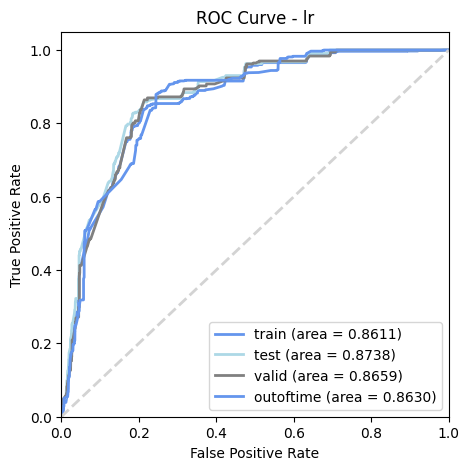

<Figure size 640x480 with 0 Axes>

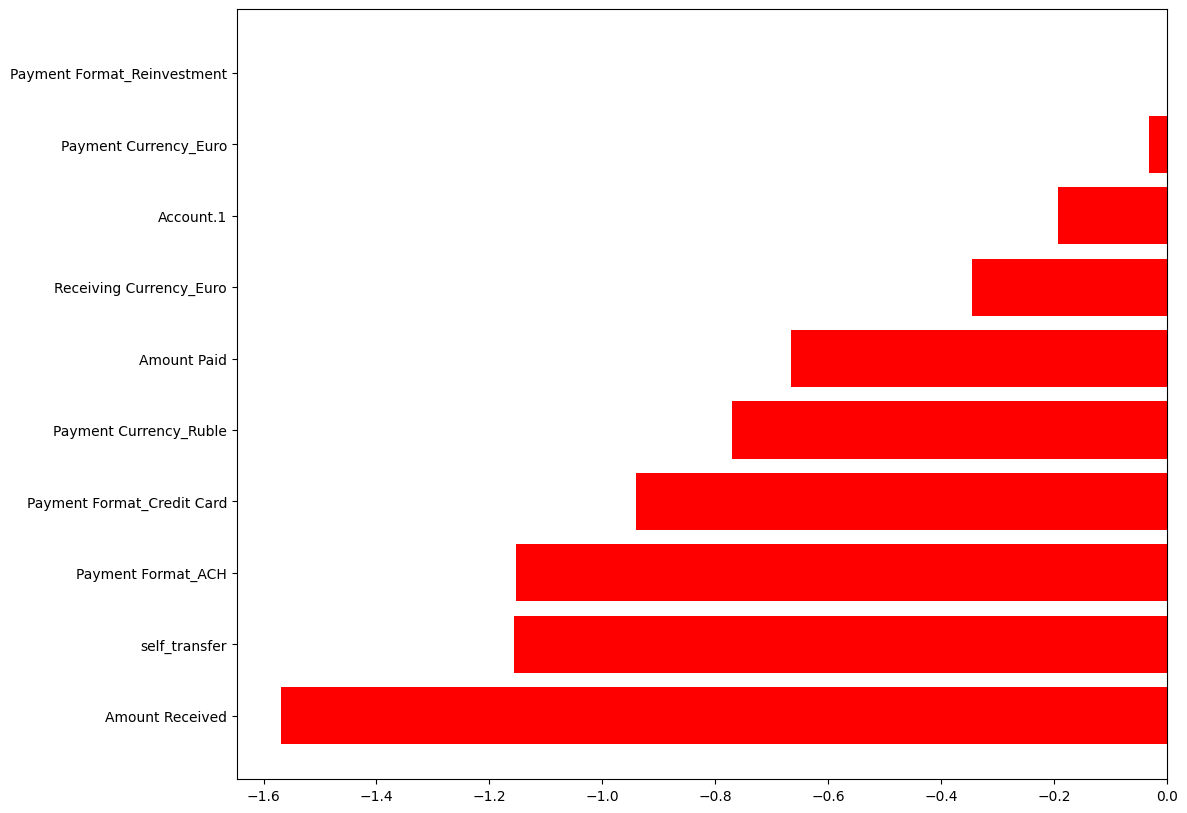

Best loss: -0.9325
Best parameters: {'C': 0.3179664193772412, 'm_method': 'rf', 'max_depth': 5, 'max_n_bins': 10, 'monotonic_trend': 'auto', 'n_estimators': 200, 'num_features': 10, 'binning_fit_params': {'Amount Received': {'monotonic_trend': 'descending'}, 'Amount Paid': {'monotonic_trend': 'ascending'}, 'Payment Format_ACH': {'monotonic_trend': 'ascending'}, 'Payment Format_Cheque': {'monotonic_trend': 'auto'}, 'Payment Format_Credit Card': {'monotonic_trend': 'auto'}, 'Payment Currency_Euro': {'monotonic_trend': 'ascending'}, 'Payment Currency_US Dollar': {'monotonic_trend': 'ascending'}, 'Receiving Currency_Euro': {'monotonic_trend': 'ascending'}, 'Receiving Currency_US Dollar': {'monotonic_trend': 'ascending'}, 'self_transfer': {'monotonic_trend': 'descending'}, 'Account.1': {'monotonic_trend': 'ascending'}, 'Payment Format_Bitcoin': {'monotonic_trend': 'auto'}, 'Payment Format_Cash': {'monotonic_trend': 'auto'}, 'Payment Format_Reinvestment': {'monotonic_trend': 'auto'}, 'Paymen

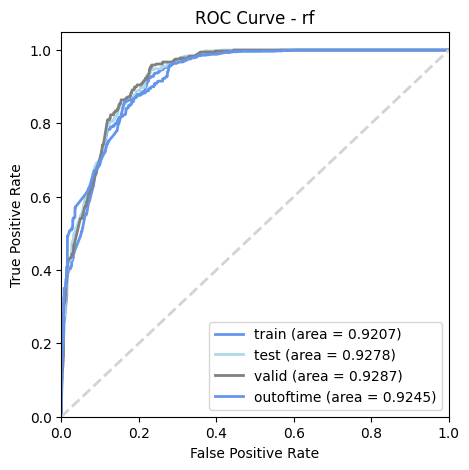

<Figure size 640x480 with 0 Axes>

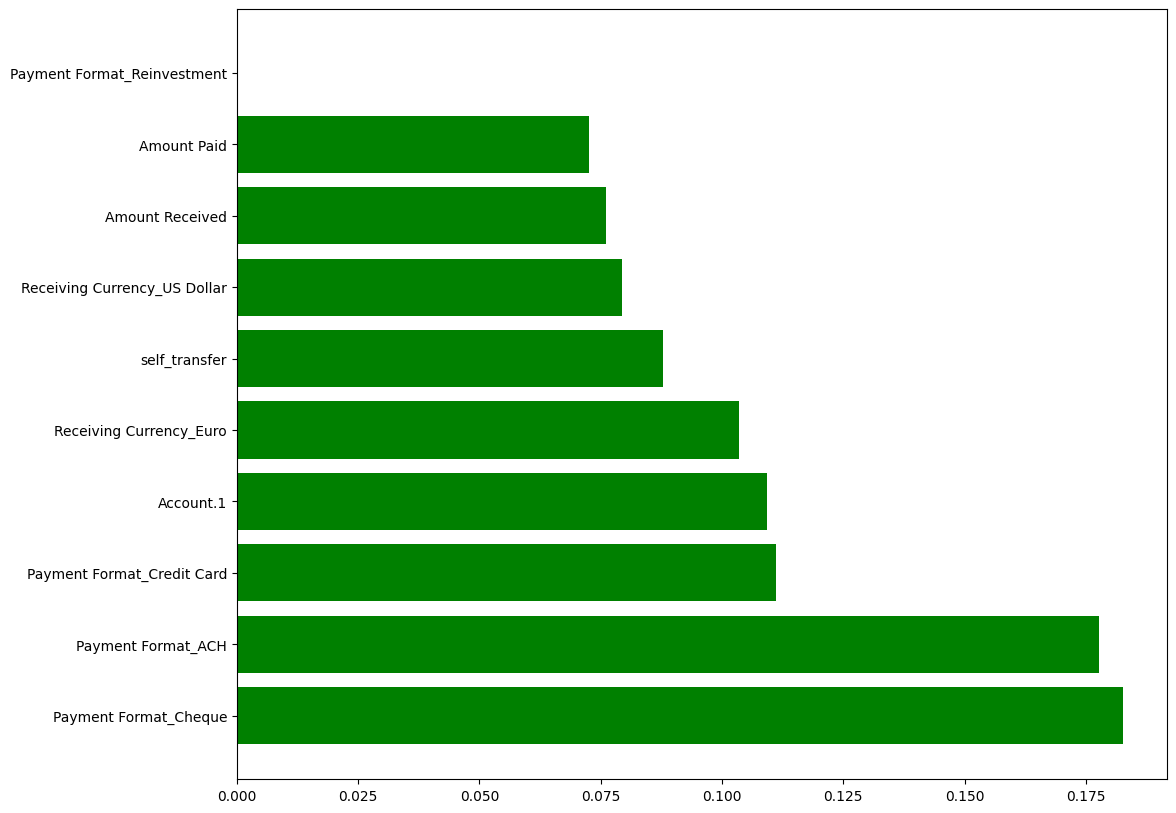

In [203]:
# Step 6: Final Fit and Feature Importance Ranking
# Set thresholds (e.g., recall thresholds)
threshold_list = [round(0.1 * i, 1) for i in range(10) if i > 0]

# Define model and sample combinations
model_list = ['lr', 'rf']
list_of_samp = [['test'], ['outoftime'], ['test', 'outoftime']]

# Final model fitting with best parameters from Step 05
score_df = final_fitting_overall(model_list, df, features)

# Save the prediction results
score_df.to_csv(model_dir + "/model_predictions.csv", index=False)

In [208]:
score_df.head()

,Account,Is Laundering,X_fold,biz_dt,lr,rf
0,80110A550,0,train,2022/09/01,0.000477,0.000126
1,80DD6C310,0,train,2022/09/02,0.000392,0.000210
2,808D34900,0,train,2022/09/06,0.000392,0.000030
3,80D7E0F70,0,train,2022/09/03,0.007591,0.010763
4,811CE6480,0,train,2022/09/02,0.020485,0.059426


In [209]:
def model_performance_metrics(model_name, y_test, y_prob, mythreshold):

    y_pred = (y_prob >= mythreshold).astype(int)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()

    Accuracy = (tp + tn) / (tp + tn + fp + fn)
    Precision = tp / (tp + fp) if (tp + fp) else 0
    Recall = tp / (tp + fn) if (tp + fn) else 0
    F1_score = 2 * Precision * Recall / (Precision + Recall) if (Precision + Recall) else 0

    metrics_df = pd.DataFrame([[
        model_name, Accuracy, Precision, Recall, F1_score, auc,
        tn, fp, fn, tp, (tp + tn + fp + fn), mythreshold
    ]], columns=[
        'Model name', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUROC',
        'TN', 'FP', 'FN', 'TP', 'Total', 'Threshold'
    ])

    return metrics_df

In [210]:
def mpr_report(model_list, list_of_samp, threshold_list, df, target):
    mpm = pd.DataFrame()

    for mo in model_list:
        for sam in list_of_samp:
            for thr in threshold_list:
                if all(i in [['poso'], ['tmx'], ['mm']] for i in [sam]):
                    # get max score of poso and tmx across all business dt
                    eda = df[df["X_fold"].str.lower().isin(sam)].copy(deep=True)
                    eda = eda.groupby(["cif_no", target])[mo].max().to_frame().reset_index().copy(deep=True)
                else:
                    eda = df[df["X_fold"].isin(sam)].copy(deep=True)

                eda["mypred"] = (eda[mo] >= thr).astype(int)

                tmp = model_performance_metrics(mo, eda[target], eda["mypred"], thr)
                tmp["sample"] = str(sam)

                mpm = pd.concat([mpm, tmp])

    return mpm[["Model name", "Accuracy", "Precision", "Recall", "F1_score", "AUROC",
                "TN", "FP", "FN", "TP", "Total", "Threshold", "sample"]]


In [212]:
# Run MPRs for different segments
mpr_all = mpr_report(model_list, [['test'], ['outoftime'], ['test', 'outoftime']], threshold_list, score_df, target)
mpr_all.to_csv(model_dir + "/model_performance_metrics_All.csv", index=False)
mpr_all.head()

,Model name,Accuracy,Precision,Recall,F1_score,AUROC,TN,FP,FN,TP,Total,Threshold,sample
0,lr,0.998122,0.0,0.0,0.0,0.5,229055,0,431,0,229486,0.1,['test']
0,lr,0.998122,0.0,0.0,0.0,0.5,229055,0,431,0,229486,0.2,['test']
0,lr,0.998122,0.0,0.0,0.0,0.5,229055,0,431,0,229486,0.3,['test']
0,lr,0.998122,0.0,0.0,0.0,0.5,229055,0,431,0,229486,0.4,['test']
0,lr,0.998122,0.0,0.0,0.0,0.5,229055,0,431,0,229486,0.5,['test']


In [217]:
# Feature Consolidation
features_df = pd.DataFrame({'features': features})

# Aggregate feature importance from each model
for mo in model_list:
    tmp = pd.read_csv(f"{model_dir}/{mo}/{mo}_feature_importance.csv",
                      names=["features", "Imp"], header=0)
    tmp = tmp.set_index("features").reset_index()[["features", "Imp"]]
    tmp["Imp"] = tmp["Imp"].abs()

    # Normalize importance values between 0–1
    tmp["Imp"] = tmp["Imp"].apply(lambda x: 0 if math.isnan(x) else (x - tmp["Imp"].min()) / (tmp["Imp"].max() - tmp["Imp"].min()))
    tmp = tmp.rename(columns={"Imp": f"Imp_{mo}"})

    features_df = features_df.merge(tmp, on="features", how="left")
features_df

,features,Imp_lr,Imp_rf
0,Amount Received,1.000000,0.416637
1,Amount Paid,0.423994,0.397877
2,Payment Format_ACH,0.735308,0.973103
3,Payment Format_Bitcoin,NaN,NaN
4,Payment Format_Cash,NaN,NaN
5,Payment Format_Cheque,NaN,1.000000
6,Payment Format_Credit Card,0.599516,0.609169
7,Payment Format_Reinvestment,0.000000,0.000000
8,Payment Format_Wire,NaN,NaN
9,Payment Currency_Australian Dollar,NaN,NaN


In [130]:
len(selected_features)

10

Amount Received


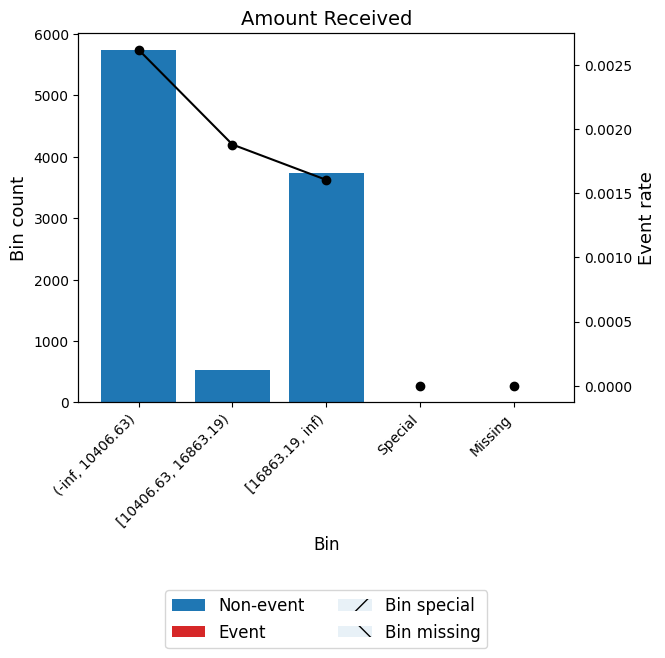

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 10406.63)",5727,0.5727,5712,15,0.002619,-0.174821,0.019118,0.002387
1,"[10406.63, 16863.19)",532,0.0532,531,1,0.001880,0.157667,0.001224,0.000153
2,"[16863.19, inf)",3741,0.3741,3735,6,0.001604,0.316648,0.032170,0.004005
3,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.052512,0.006544


In [132]:
i = 0
print(selected_features[i])
# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True)
binned_var.binning_table.build()

Amount Paid


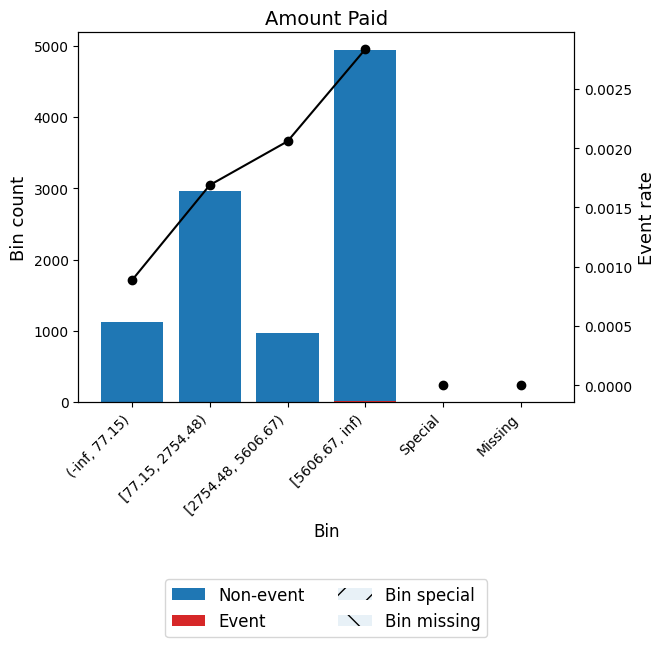

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 77.15)",1128,0.1128,1127,1,0.000887,0.910219,0.061434,0.007425
1,"[77.15, 2754.48)",2961,0.2961,2956,5,0.001689,0.265059,0.018284,0.002279
2,"[2754.48, 5606.67)",972,0.0972,970,2,0.002058,0.067053,0.000423,0.000053
3,"[5606.67, inf)",4939,0.4939,4925,14,0.002835,-0.254073,0.036276,0.004522
4,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.116417,0.014279


In [133]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True)
binned_var.binning_table.build()

Payment Format_ACH


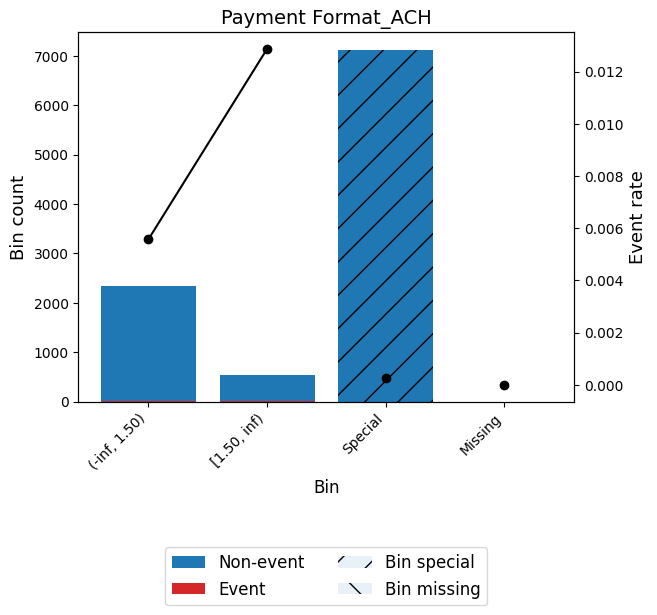

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",2332,0.2332,2319,13,0.005575,-0.933154,0.334533,0.040363
1,"[1.50, inf)",544,0.0544,537,7,0.012868,-1.777008,0.469776,0.052041
2,Special,7124,0.7124,7122,2,0.000281,2.060701,1.283531,0.136979
3,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,2.087840,0.229383


In [134]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True)
binned_var.binning_table.build()

Payment Format_Cheque


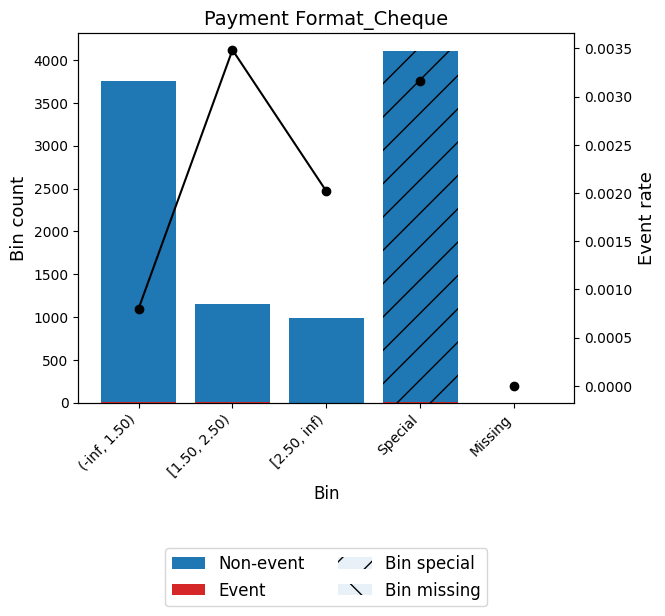

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",3751,0.3751,3748,3,0.000800,1.01327,0.242438,0.029071
1,"[1.50, 2.50)",1148,0.1148,1144,4,0.003484,-0.461104,0.030970,0.003837
2,"[2.50, inf)",991,0.0991,989,2,0.002018,0.086452,0.000710,0.000089
3,Special,4110,0.4110,4097,13,0.003163,-0.364035,0.065638,0.008160
4,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.339755,0.041157


In [135]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True)
binned_var.binning_table.build()

Payment Format_Credit Card


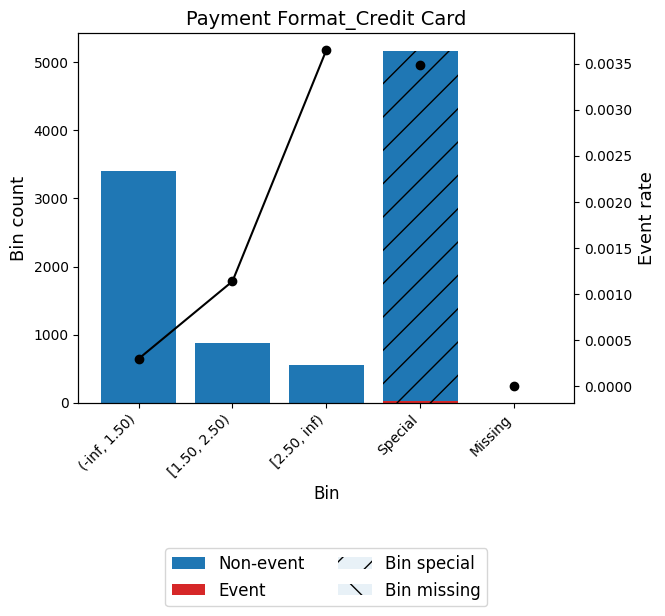

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",3402,0.3402,3401,1,0.000294,2.014729,0.595142,0.063914
1,"[1.50, 2.50)",880,0.0880,879,1,0.001136,0.661689,0.028214,0.003464
2,"[2.50, inf)",548,0.0548,546,2,0.003650,-0.507624,0.018370,0.002272
3,Special,5170,0.5170,5152,18,0.003482,-0.460327,0.138948,0.017217
4,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.780674,0.086867


In [136]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

Payment Currency_Euro


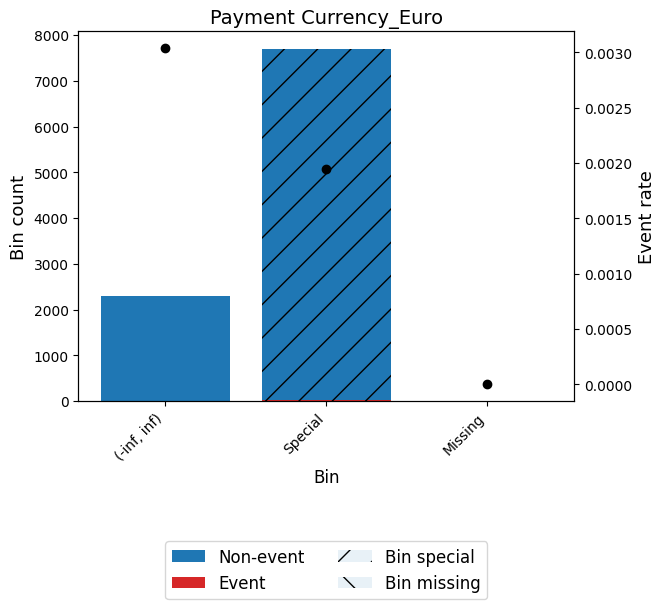

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",2305,0.2305,2298,7,0.003037,-0.323211,0.028402,0.003535
1,Special,7695,0.7695,7680,15,0.001949,0.121229,0.010653,0.001331
2,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.039055,0.004866


In [137]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

Payment Currency_US Dollar


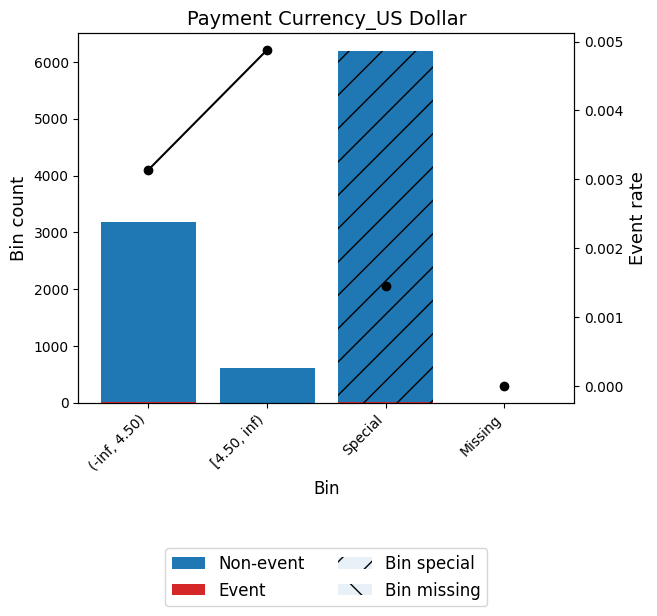

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 4.50)",3187,0.3187,3177,10,0.003138,-0.355988,0.048466,0.006026
1,"[4.50, inf)",615,0.0615,612,3,0.004878,-0.798976,0.059946,0.007300
2,Special,6198,0.6198,6189,9,0.001452,0.416209,0.087892,0.010908
3,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.196304,0.024234


In [138]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

Receiving Currency_US Dollar


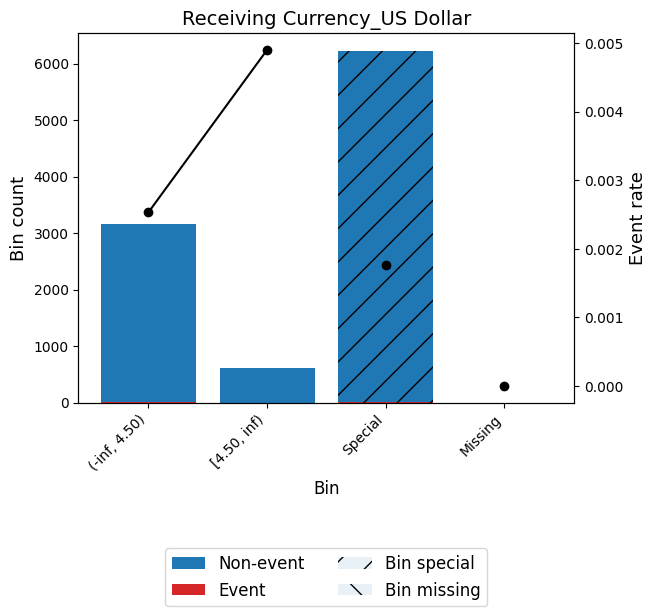

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 4.50)",3159,0.3159,3151,8,0.002532,-0.141062,0.006749,0.000843
1,"[4.50, inf)",612,0.0612,609,3,0.004902,-0.80389,0.060556,0.007372
2,Special,6229,0.6229,6218,11,0.001766,0.220213,0.027124,0.003384
3,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.094429,0.011599


In [139]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

self_transfer


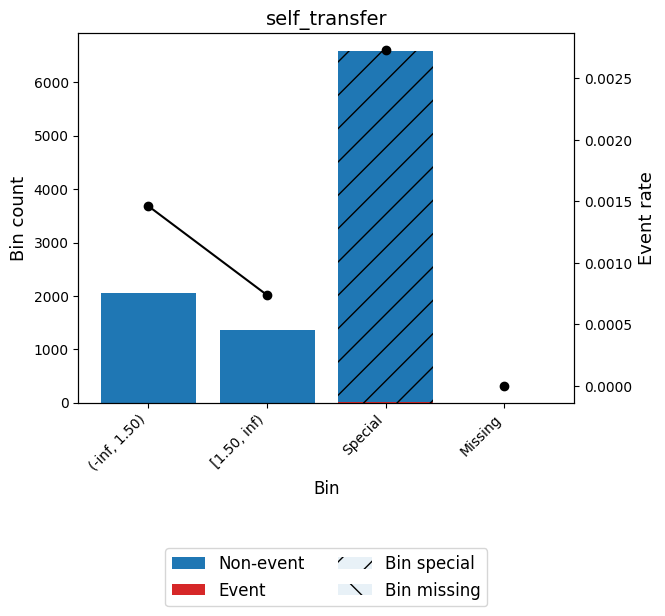

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",2053,0.2053,2050,3,0.001461,0.409887,0.028318,0.003515
1,"[1.50, inf)",1355,0.1355,1354,1,0.000738,1.093723,0.098702,0.011757
2,Special,6592,0.6592,6574,18,0.002731,-0.216589,0.034510,0.004305
3,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.161530,0.019578


In [140]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

Account.1


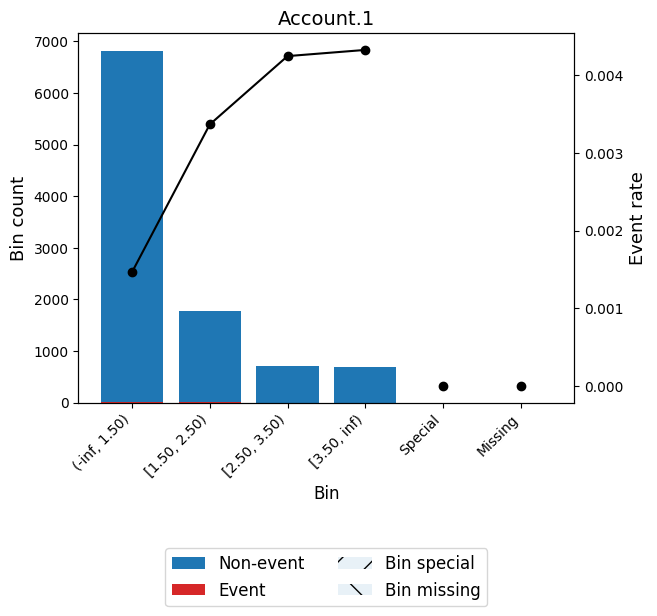

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",6820,0.6820,6810,10,0.001466,0.406467,0.092657,0.011503
1,"[1.50, 2.50)",1781,0.1781,1775,6,0.003369,-0.427299,0.040523,0.005027
2,"[2.50, 3.50)",706,0.0706,703,3,0.004249,-0.660351,0.043523,0.005344
3,"[3.50, inf)",693,0.0693,690,3,0.004329,-0.679016,0.045638,0.005598
4,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.222340,0.027471


In [141]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

END